# 0. Importar librerias

In [ ]:
!pip install transformers==4.12.2

In [1]:
from tqdm import tqdm # Barra de progreso
from collections import Counter

#Pandas
import pandas as pd
from pandasql import sqldf

#Spacy
import spacy
from spacy.matcher import PhraseMatcher
from spacy.matcher import Matcher
nlp = spacy.load("es_core_news_md")

#Transformers
model_name = "finiteautomata/beto-sentiment-analysis"
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

#Pandas, Numpy, Matplotlib, Seaborn
import geopandas as gpd
import shapely as shp
import pandas
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors

KeyboardInterrupt: 

# 1. Leer dataset de las noticias del territorio

In [19]:
FILE = "./noticias_losrios_2022.csv"

In [22]:
dataset = pd.read_csv(FILE)
dataset.drop('Unnamed: 0', axis=1, inplace=True)
dataset

,id_news,country,media_outlet,url,title,text,date,search
0,47314428.0,chile,suractual,https://www.suractual.cl/2022/01/24/ante-proye...,Ante proyecto Tierras Raras municipio y Unión ...,“Considerando la evolución que ha tenido el Pr...,2022-01-24,NaN
1,47719086.0,chile,noticiaslosrios,https://www.noticiaslosrios.cl/2022/01/25/trac...,Tractocamión volcó esta mañana en puente Lloll...,El accidente se produjo pasadas las 06:00 AM y...,2022-01-25,NaN
2,47719110.0,chile,noticiaslosrios,https://www.noticiaslosrios.cl/2022/01/27/gobe...,Gobernadores Regionales de Los Ríos y Los Lago...,La instancia buscó generar un trabajo colabora...,2022-01-27,NaN
3,47700339.0,chile,diariolaguino,https://www.diariolaguino.cl/noticia/actualida...,Alegan inocencia de acusadas por cruel asesina...,La defensa de las dos mujeres acusadas de enca...,2022-01-05,NaN
4,47700425.0,chile,diariolaguino,https://www.diariolaguino.cl/noticia/actualida...,Destacan ejecución del Programa Vínculos en Lo...,Para dar protección y acompañamiento a adultos...,2022-01-03,NaN
...,...,...,...,...,...,...,...,...
15142,50428917.0,chile,diariolaguino,https://www.diariolaguino.cl/noticia/educacion...,Admisión 2023: Caravana Técnico Profesional de...,Desde este lunes 12 y hasta el miércoles 14 de...,2022-12-13,NaN
15143,50428943.0,chile,diariolaguino,https://www.diariolaguino.cl/noticia/emergenci...,Triple colisión en Los Lagos deja al menos un ...,Tres vehículos se vieron involucrados en un ac...,2022-12-07,NaN
15144,50428975.0,chile,diariolaguino,https://www.diariolaguino.cl/noticia/opinion/2...,Columna de opinión: No quedó ni el sombrero - ...,“Somos en realidad sacos llenos de cosas inédi...,2022-12-09,NaN
15145,50429002.0,chile,diariolaguino,https://www.diariolaguino.cl/noticia/emergenci...,Triste despertar en Los Lagos: comunidad lamen...,Un triste despertar ha tenido este domingo la ...,2022-12-04,NaN


# 2. Etiquetar las comunas mencionadas

In [24]:
CITIES = ["Valdivia", "Mariquina", "Lanco", "Máfil", "Corral",
          "Paillaco", "Panguipulli", "La Unión", "Río Bueno", "Futrono",
         "Los Lagos", "Lago Ranco"]

In [25]:
dataset_cities = dataset

In [26]:
matcher_cities = PhraseMatcher(nlp.vocab)

for city in CITIES:
    matcher_cities.add(city, [nlp(city)])
    dataset_cities.insert(8,city.replace(" ","_"),0)
    
dataset_cities.columns.values

array(['id_news', 'country', 'media_outlet', 'url', 'title', 'text',
       'date', 'search', 'Lago_Ranco', 'Los_Lagos', 'Futrono',
       'Río_Bueno', 'La_Unión', 'Panguipulli', 'Paillaco', 'Corral',
       'Máfil', 'Lanco', 'Mariquina', 'Valdivia'], dtype=object)

In [27]:
for index,row in dataset_cities.iterrows():
    print(index)
    txt = row["text"]
    
    try:
        doc = nlp(txt)
        matches_cities = matcher_cities(doc)

        for match_id, start, end in matches_cities:
            span = doc[start:end]  # The matched span
            dataset_cities.at[index,span.text.replace(" ","_")]=1
    
    except Exception as e:
        print(e)
        pass

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065


3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711


5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309


6708
6709
6710
6711
6712
6713
6714
6715
6716
6717
6718
6719
6720
6721
6722
6723
6724
6725
6726
6727
6728
6729
6730
6731
6732
6733
6734
6735
6736
6737
6738
6739
6740
6741
6742
6743
6744
6745
6746
6747
6748
6749
6750
6751
6752
6753
6754
6755
6756
6757
6758
6759
6760
6761
6762
6763
6764
6765
6766
6767
6768
6769
6770
6771
6772
6773
6774
6775
6776
6777
6778
6779
6780
6781
6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
[E1041] Expected a string, Doc, or bytes as input, but got: <class 'float'>
6884
6885
6886
6887
6888
6889
6890
6891
6892

8318
8319
8320
8321
8322
8323
8324
8325
8326
8327
8328
8329
8330
8331
8332
8333
8334
8335
8336
8337
8338
8339
8340
8341
8342
8343
8344
8345
8346
8347
8348
8349
8350
8351
8352
8353
8354
8355
8356
8357
8358
8359
8360
8361
8362
8363
8364
8365
8366
8367
8368
8369
8370
8371
8372
8373
8374
8375
8376
8377
8378
8379
8380
8381
8382
8383
8384
8385
8386
8387
8388
8389
8390
8391
8392
8393
8394
8395
8396
8397
8398
8399
8400
8401
8402
8403
8404
8405
8406
8407
8408
8409
8410
8411
8412
8413
8414
8415
8416
8417
8418
8419
8420
8421
8422
8423
8424
8425
8426
8427
8428
8429
8430
8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517


9960
9961
9962
9963
9964
9965
9966
9967
9968
9969
9970
9971
9972
9973
9974
9975
9976
9977
9978
9979
9980
9981
9982
9983
9984
9985
9986
9987
9988
9989
9990
9991
9992
9993
9994
9995
9996
9997
9998
9999
10000
10001
10002
10003
10004
10005
10006
10007
10008
10009
10010
10011
10012
10013
10014
10015
10016
10017
10018
10019
10020
10021
10022
10023
10024
10025
10026
10027
10028
10029
10030
10031
10032
10033
10034
10035
10036
10037
10038
10039
10040
10041
10042
10043
10044
10045
10046
10047
10048
10049
10050
10051
10052
10053
10054
10055
10056
10057
10058
10059
10060
10061
10062
10063
10064
10065
10066
10067
10068
10069
10070
10071
10072
10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10

11341
11342
11343
11344
11345
11346
11347
11348
11349
11350
11351
11352
11353
11354
11355
11356
11357
11358
11359
11360
11361
11362
11363
11364
11365
11366
11367
11368
11369
11370
11371
11372
11373
11374
11375
11376
11377
11378
11379
11380
11381
11382
11383
11384
11385
11386
11387
11388
11389
11390
11391
11392
11393
11394
11395
11396
11397
11398
11399
11400
11401
11402
11403
11404
11405
11406
11407
11408
11409
11410
11411
11412
11413
11414
11415
11416
11417
11418
11419
11420
11421
11422
11423
11424
11425
11426
11427
11428
11429
11430
11431
11432
11433
11434
11435
11436
11437
11438
11439
11440
11441
11442
11443
11444
11445
11446
11447
11448
11449
11450
11451
11452
11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
1150

12695
12696
12697
12698
12699
12700
12701
12702
12703
12704
12705
12706
12707
12708
12709
12710
12711
12712
12713
12714
12715
12716
12717
12718
12719
12720
12721
12722
12723
12724
12725
12726
12727
12728
12729
12730
12731
12732
12733
12734
12735
12736
12737
12738
12739
12740
12741
12742
12743
12744
12745
12746
12747
12748
12749
12750
12751
12752
12753
12754
12755
12756
12757
12758
12759
12760
12761
12762
12763
12764
12765
12766
12767
12768
12769
12770
12771
12772
12773
12774
12775
12776
12777
12778
12779
12780
12781
12782
12783
12784
12785
12786
12787
12788
12789
12790
12791
12792
12793
12794
12795
12796
12797
12798
12799
12800
12801
12802
12803
12804
12805
12806
12807
12808
12809
12810
12811
12812
12813
12814
12815
12816
12817
12818
12819
12820
12821
12822
12823
12824
12825
12826
12827
12828
12829
12830
12831
12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
1286

14065
14066
14067
14068
14069
14070
14071
14072
14073
14074
14075
14076
14077
14078
14079
14080
14081
14082
14083
14084
14085
14086
14087
14088
14089
14090
14091
14092
14093
14094
14095
14096
14097
14098
14099
14100
14101
14102
14103
14104
14105
14106
14107
14108
14109
14110
14111
14112
14113
14114
14115
14116
14117
14118
14119
14120
14121
14122
14123
14124
14125
14126
14127
14128
14129
14130
14131
14132
14133
14134
14135
14136
14137
14138
14139
14140
14141
14142
14143
14144
14145
14146
14147
14148
14149
14150
14151
14152
14153
14154
14155
14156
14157
14158
14159
14160
14161
14162
14163
14164
14165
14166
14167
14168
14169
14170
14171
14172
14173
14174
14175
14176
14177
14178
14179
14180
14181
14182
14183
14184
14185
14186
14187
14188
14189
14190
14191
14192
14193
14194
14195
14196
14197
14198
14199
14200
14201
14202
14203
14204
14205
14206
14207
14208
14209
14210
14211
14212
14213
14214
14215
14216
14217
14218
14219
14220
14221
14222
14223
14224
14225
14226
14227
14228
14229
14230
1423

In [29]:
dataset_cities.to_csv("noticias_losrios_2022_porcomuna.csv")
dataset_cities

,id_news,country,media_outlet,url,title,text,date,search,Lago_Ranco,Los_Lagos,Futrono,Río_Bueno,La_Unión,Panguipulli,Paillaco,Corral,Máfil,Lanco,Mariquina,Valdivia
0,47314428.0,chile,suractual,https://www.suractual.cl/2022/01/24/ante-proye...,Ante proyecto Tierras Raras municipio y Unión ...,“Considerando la evolución que ha tenido el Pr...,2022-01-24,NaN,0,0,0,0,0,0,0,0,0,0,0,0
1,47719086.0,chile,noticiaslosrios,https://www.noticiaslosrios.cl/2022/01/25/trac...,Tractocamión volcó esta mañana en puente Lloll...,El accidente se produjo pasadas las 06:00 AM y...,2022-01-25,NaN,0,0,0,0,1,0,0,0,0,0,0,0
2,47719110.0,chile,noticiaslosrios,https://www.noticiaslosrios.cl/2022/01/27/gobe...,Gobernadores Regionales de Los Ríos y Los Lago...,La instancia buscó generar un trabajo colabora...,2022-01-27,NaN,0,1,0,1,0,0,0,0,0,0,0,0
3,47700339.0,chile,diariolaguino,https://www.diariolaguino.cl/noticia/actualida...,Alegan inocencia de acusadas por cruel asesina...,La defensa de las dos mujeres acusadas de enca...,2022-01-05,NaN,0,0,0,0,0,0,0,0,0,0,0,1
4,47700425.0,chile,diariolaguino,https://www.diariolaguino.cl/noticia/actualida...,Destacan ejecución del Programa Vínculos en Lo...,Para dar protección y acompañamiento a adultos...,2022-01-03,NaN,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15142,50428917.0,chile,diariolaguino,https://www.diariolaguino.cl/noticia/educacion...,Admisión 2023: Caravana Técnico Profesional de...,Desde este lunes 12 y hasta el miércoles 14 de...,2022-12-13,NaN,0,1,0,0,0,0,0,0,0,0,0,0
15143,50428943.0,chile,diariolaguino,https://www.diariolaguino.cl/noticia/emergenci...,Triple colisión en Los Lagos deja al menos un ...,Tres vehículos se vieron involucrados en un ac...,2022-12-07,NaN,0,1,0,0,0,0,0,0,0,0,0,0
15144,50428975.0,chile,diariolaguino,https://www.diariolaguino.cl/noticia/opinion/2...,Columna de opinión: No quedó ni el sombrero - ...,“Somos en realidad sacos llenos de cosas inédi...,2022-12-09,NaN,0,0,0,0,0,0,0,0,0,0,0,0
15145,50429002.0,chile,diariolaguino,https://www.diariolaguino.cl/noticia/emergenci...,Triste despertar en Los Lagos: comunidad lamen...,Un triste despertar ha tenido este domingo la ...,2022-12-04,NaN,0,1,0,0,0,0,0,0,0,0,0,0


# 3. Clasificar las noticias según su sentimiento

In [39]:
#Agregar columnas a los datasets
dataset_cities['prediction'] = ""
dataset_cities['score'] = ""

/tmp/ipykernel_18683/4273691935.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_cities['prediction'] = ""
/tmp/ipykernel_18683/4273691935.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_cities['score'] = ""


In [41]:
for index, row in tqdm(dataset_cities.iterrows(), desc='Análisis de sentimiento', total=dataset_cities.shape[0]):
    
    sentiment_value = sentiment_pipeline(row['title'])
    
    # Insertamos en dataframe
    dataset_cities.at[index, "prediction"] = sentiment_value[0].get('label')
    dataset_cities.at[index, "score"] = sentiment_value[0].get('score')

Análisis de sentimiento: 100%|████████████| 15138/15138 [12:04<00:00, 20.88it/s]


In [44]:
dataset_cities

,id_news,country,media_outlet,url,title,text,date,search,Lago_Ranco,Los_Lagos,...,La_Unión,Panguipulli,Paillaco,Corral,Máfil,Lanco,Mariquina,Valdivia,prediction,score
0,47314428.0,chile,suractual,https://www.suractual.cl/2022/01/24/ante-proye...,Ante proyecto Tierras Raras municipio y Unión ...,“Considerando la evolución que ha tenido el Pr...,2022-01-24,NaN,0,0,...,0,0,0,0,0,0,0,0,NEU,0.988633
1,47719086.0,chile,noticiaslosrios,https://www.noticiaslosrios.cl/2022/01/25/trac...,Tractocamión volcó esta mañana en puente Lloll...,El accidente se produjo pasadas las 06:00 AM y...,2022-01-25,NaN,0,0,...,1,0,0,0,0,0,0,0,NEU,0.998064
2,47719110.0,chile,noticiaslosrios,https://www.noticiaslosrios.cl/2022/01/27/gobe...,Gobernadores Regionales de Los Ríos y Los Lago...,La instancia buscó generar un trabajo colabora...,2022-01-27,NaN,0,1,...,0,0,0,0,0,0,0,0,NEU,0.931461
3,47700339.0,chile,diariolaguino,https://www.diariolaguino.cl/noticia/actualida...,Alegan inocencia de acusadas por cruel asesina...,La defensa de las dos mujeres acusadas de enca...,2022-01-05,NaN,0,0,...,0,0,0,0,0,0,0,1,NEU,0.973683
4,47700425.0,chile,diariolaguino,https://www.diariolaguino.cl/noticia/actualida...,Destacan ejecución del Programa Vínculos en Lo...,Para dar protección y acompañamiento a adultos...,2022-01-03,NaN,0,0,...,0,0,0,0,0,0,0,1,POS,0.536478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15142,50428917.0,chile,diariolaguino,https://www.diariolaguino.cl/noticia/educacion...,Admisión 2023: Caravana Técnico Profesional de...,Desde este lunes 12 y hasta el miércoles 14 de...,2022-12-13,NaN,0,1,...,0,0,0,0,0,0,0,0,NEU,0.979722
15143,50428943.0,chile,diariolaguino,https://www.diariolaguino.cl/noticia/emergenci...,Triple colisión en Los Lagos deja al menos un ...,Tres vehículos se vieron involucrados en un ac...,2022-12-07,NaN,0,1,...,0,0,0,0,0,0,0,0,NEG,0.716544
15144,50428975.0,chile,diariolaguino,https://www.diariolaguino.cl/noticia/opinion/2...,Columna de opinión: No quedó ni el sombrero - ...,“Somos en realidad sacos llenos de cosas inédi...,2022-12-09,NaN,0,0,...,0,0,0,0,0,0,0,0,NEG,0.977032
15145,50429002.0,chile,diariolaguino,https://www.diariolaguino.cl/noticia/emergenci...,Triste despertar en Los Lagos: comunidad lamen...,Un triste despertar ha tenido este domingo la ...,2022-12-04,NaN,0,1,...,0,0,0,0,0,0,0,0,NEG,0.997505


# 4. Buscar palabras claves relevantes en un ámbito temático

In [45]:
TOPIC="turismo"
PALABRAS_CLAVES=["feria","visitantes","alojamiento","actividades turísticas",
                   "transporte","gastronomía","ecoturismo","cultura local","guía turístico",
                   "parques","patrimonio","agencia de viajes","tour","turista","turistas",
                  "aventura","termas","gastronomia","reserva",
                  "senderismo","restaurant","trekking","parque","esquí","atractivos","eventos",
                  "hospedaje","panoramas","restaurante", "viaje",
                  "hotel", "playa", "vacaciones","alojamiento", "turismo", "artesanía","turísticos","cultura"]

In [46]:
# Eliminar filas con valores NaN en la columna 'text'
dataset_cities = dataset_cities.dropna(subset=['text'])

In [47]:
# Define una función para buscar palabras claves en un texto y devolver una lista de palabras clave encontradas
def find_keywords(text):
    words_found = []
    for word in PALABRAS_CLAVES:
        if word in text.lower():
            words_found.append(word)
    return words_found

In [48]:
# Agrega una nueva columna 'keywords_found'
dataset_cities['keywords_found'] = dataset_cities['text'].apply(find_keywords)

# Filtra el DataFrame para guardar solo las filas que contienen más de 1 una de las palabras claves
dataset_cities_topic = dataset_cities[dataset_cities['keywords_found'].map(len) > 1]


dataset_cities_topic = dataset_cities_topic.sort_values(by='keywords_found', key=lambda x: x.str.len(), ascending=False)

In [51]:
dataset_cities

,id_news,country,media_outlet,url,title,text,date,search,Lago_Ranco,Los_Lagos,...,Panguipulli,Paillaco,Corral,Máfil,Lanco,Mariquina,Valdivia,prediction,score,keywords_found
0,47314428.0,chile,suractual,https://www.suractual.cl/2022/01/24/ante-proye...,Ante proyecto Tierras Raras municipio y Unión ...,“Considerando la evolución que ha tenido el Pr...,2022-01-24,NaN,0,0,...,0,0,0,0,0,0,0,NEU,0.988633,[]
1,47719086.0,chile,noticiaslosrios,https://www.noticiaslosrios.cl/2022/01/25/trac...,Tractocamión volcó esta mañana en puente Lloll...,El accidente se produjo pasadas las 06:00 AM y...,2022-01-25,NaN,0,0,...,0,0,0,0,0,0,0,NEU,0.998064,[]
2,47719110.0,chile,noticiaslosrios,https://www.noticiaslosrios.cl/2022/01/27/gobe...,Gobernadores Regionales de Los Ríos y Los Lago...,La instancia buscó generar un trabajo colabora...,2022-01-27,NaN,0,1,...,0,0,0,0,0,0,0,NEU,0.931461,"[reserva, parque, turismo]"
3,47700339.0,chile,diariolaguino,https://www.diariolaguino.cl/noticia/actualida...,Alegan inocencia de acusadas por cruel asesina...,La defensa de las dos mujeres acusadas de enca...,2022-01-05,NaN,0,0,...,0,0,0,0,0,0,1,NEU,0.973683,[]
4,47700425.0,chile,diariolaguino,https://www.diariolaguino.cl/noticia/actualida...,Destacan ejecución del Programa Vínculos en Lo...,Para dar protección y acompañamiento a adultos...,2022-01-03,NaN,0,0,...,0,0,0,0,0,0,1,POS,0.536478,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15142,50428917.0,chile,diariolaguino,https://www.diariolaguino.cl/noticia/educacion...,Admisión 2023: Caravana Técnico Profesional de...,Desde este lunes 12 y hasta el miércoles 14 de...,2022-12-13,NaN,0,1,...,0,0,0,0,0,0,0,NEU,0.979722,[]
15143,50428943.0,chile,diariolaguino,https://www.diariolaguino.cl/noticia/emergenci...,Triple colisión en Los Lagos deja al menos un ...,Tres vehículos se vieron involucrados en un ac...,2022-12-07,NaN,0,1,...,0,0,0,0,0,0,0,NEG,0.716544,[]
15144,50428975.0,chile,diariolaguino,https://www.diariolaguino.cl/noticia/opinion/2...,Columna de opinión: No quedó ni el sombrero - ...,“Somos en realidad sacos llenos de cosas inédi...,2022-12-09,NaN,0,0,...,0,0,0,0,0,0,0,NEG,0.977032,[aventura]
15145,50429002.0,chile,diariolaguino,https://www.diariolaguino.cl/noticia/emergenci...,Triste despertar en Los Lagos: comunidad lamen...,Un triste despertar ha tenido este domingo la ...,2022-12-04,NaN,0,1,...,0,0,0,0,0,0,0,NEG,0.997505,[]


# 5. Cantidad de noticias por comuna: Figura 1

In [52]:
df_all = dataset_cities.drop('keywords_found', axis=1)
df_topic = dataset_cities_topic.drop('keywords_found', axis=1)

In [57]:
pysqldf = lambda q: sqldf(q, globals())

query = """
SELECT sum("La_Unión") as "La Unión",
sum("Los_Lagos")as "Los Lagos",
sum(Máfil)as Máfil,
sum(Paillaco) as Paillaco,
sum(Lanco) as Lanco,
sum(Panguipulli) as Panguipulli,
sum("Río_Bueno") as "Río Bueno",
sum(Mariquina) as Mariquina,
sum(Corral) as Corral,
sum(Valdivia) as Valdivia,
sum("Lago_Ranco") as "Lago Ranco",
sum(Futrono) as Futrono 
FROM df_all
"""

print("Cantidad de noticias total en 2022")
query1=pysqldf(query)
query1

Cantidad de noticias total en 2022


,La Unión,Los Lagos,Máfil,Paillaco,Lanco,Panguipulli,Río Bueno,Mariquina,Corral,Valdivia,Lago Ranco,Futrono
0,1785,1694,423,1847,687,1251,1224,688,631,6923,720,1421


In [58]:
query = """
SELECT sum("La_Unión") as "La Unión",
sum("Los_Lagos")as "Los Lagos",
sum(Máfil)as Máfil,
sum(Paillaco) as Paillaco,
sum(Lanco) as Lanco,
sum(Panguipulli) as Panguipulli,
sum("Río_Bueno") as "Río Bueno",
sum(Mariquina) as Mariquina,
sum(Corral) as Corral,
sum(Valdivia) as Valdivia,
sum("Lago_Ranco") as "Lago Ranco",
sum(Futrono) as Futrono 
FROM df_topic
"""

print("Cantidad de noticias en 2022 sobre el tópico")
query2=pysqldf(query)
query2

Cantidad de noticias en 2022 sobre el tópico


,La Unión,Los Lagos,Máfil,Paillaco,Lanco,Panguipulli,Río Bueno,Mariquina,Corral,Valdivia,Lago Ranco,Futrono
0,257,169,43,149,82,198,115,85,129,742,117,186


In [59]:
print("Tasa de noticias sobre el tópico")

ratio = query2 / query1.values
ratio

Tasa de noticias sobre el tópico


,La Unión,Los Lagos,Máfil,Paillaco,Lanco,Panguipulli,Río Bueno,Mariquina,Corral,Valdivia,Lago Ranco,Futrono
0,0.143978,0.099764,0.101655,0.080671,0.11936,0.158273,0.093954,0.123547,0.204437,0.107179,0.1625,0.130894


# 6. Métodos para la visualización de mapas

In [63]:
SHAPEFILE=r'./shape/comunas.shp' #shapefile de las regiones y comunas de Chile
REGION = 14 #Los Rios

# fuente: https://www.bcn.cl/siit/mapas_vectoriales

In [68]:
territory = gpd.read_file(SHAPEFILE, encoding='utf-8')
territory = territory[territory["codregion"] == REGION]
# Obtenemos los datos de las Columnas "Comuna", "geometry"
territory = territory[["Comuna", "geometry"]]

In [69]:
def save_map(df, territory, image_name: str = "Mapa_Calor"):
    
    #Junta las tablas df y Pais
    territory = territory.merge(df, on = "Comuna")
    
    #Inicializa matplotlib para la creacion del mapa
    fig, ax = plt.subplots(figsize=(10, 10))
    max_presente = df.max()[1]#valore maximo para la barra de calor
    territory.plot(column = 'Valor',ax=ax,edgecolor = "gray", cmap = 'OrRd', legend = False).set_axis_off()
    bar_info = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=0,vmax=max_presente))
    bar_info._A = []
    cbar = fig.colorbar(bar_info)
    
    #Guardar imagen en nombre_imagen
    plt.savefig('.//{}.svg'.format(image_name), bbox_inches = "tight",transparent = True)

# 7. Visualizar mapa de las comunas mostrando la tasa de noticias sobre el tópico: Figura 2

La Unión
Los Lagos
Máfil
Paillaco
Lanco
Panguipulli
Río Bueno
Mariquina
Corral
Valdivia
Lago Ranco
Futrono


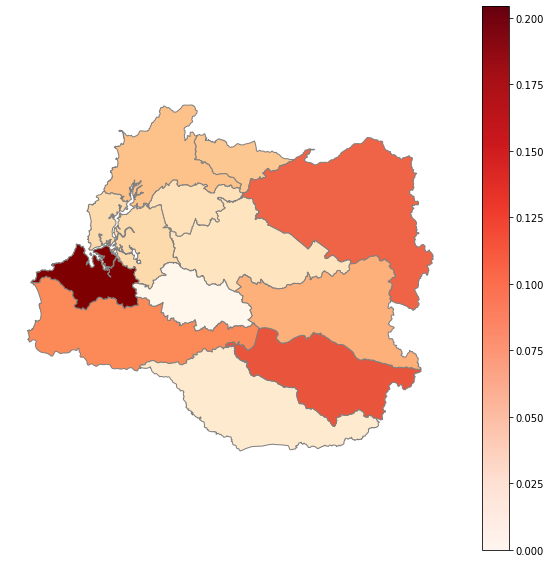

In [70]:
df=ratio

lista =[]
cont = 0
for i in territory["Comuna"]:
    print(i)
    lista.append({"Comuna": i, "Valor": df.iloc[0][cont]})
    cont +=1
df = pandas.DataFrame(lista)

save_map(df, territory, "mapa")
plt.savefig("mapa.png", dpi=500)

# 8. Mostrar la relación entre la cantidad de habitantes y el número de noticias sobre el tópico: Figura 3

In [74]:
# Crear dataframe que relaciona el número de habitantes y la cantidad de noticias sobre el tópico, por cada comuna
datos = {'Comuna': ['Valdivia', 'La Unión', 'Futrono', 'Los Lagos', 'Panguipulli', 'Paillaco', 'Río Bueno', 'Corral', 'Lago Ranco', 'Lanco', 'Mariquina', 'Máfil'],
         'Noticias': [742, 257, 186, 169, 198, 149, 115, 129, 117, 82, 85, 43],
         'Habitantes': [166080, 38036, 14665, 19634, 34539, 20188, 31372, 5302, 9896, 16752, 21278, 7095]}
df = pd.DataFrame(datos)
df

,Comuna,Noticias,Habitantes
0,Valdivia,742,166080
1,La Unión,257,38036
2,Futrono,186,14665
3,Los Lagos,169,19634
4,Panguipulli,198,34539
5,Paillaco,149,20188
6,Río Bueno,115,31372
7,Corral,129,5302
8,Lago Ranco,117,9896
9,Lanco,82,16752


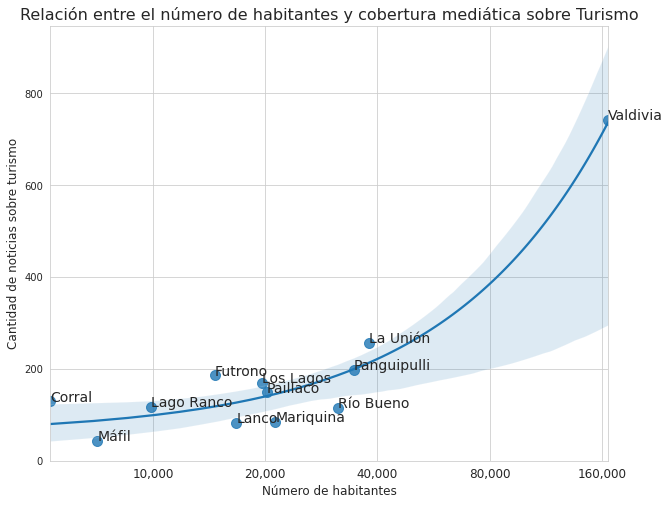

In [75]:
# Crear gráfico
sns.set_style('whitegrid') # Agregado para cambiar el estilo
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.regplot(x='Habitantes', y='Noticias', data=df, scatter_kws={"s": 100})

# Escala logarítmica en el eje X
ax.set_xscale('log')

# Formatear los ticks del eje X para que muestren los números de habitantes completos
def format_tick(x, pos):
    return '{:,.0f}'.format(x)

ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_tick))

# Configuración del eje X
ticks = [10000, 20000, 40000, 80000, 160000]
ax.set_xticks(ticks)
ax.set_xticklabels([f"{t:,}" for t in ticks], fontsize=12)

# Agregar nombres de comunas
for i in range(len(df)):
        ax.annotate(df.iloc[i]['Comuna'], (df.iloc[i]['Habitantes'], df.iloc[i]['Noticias']), fontsize=14)

# Añadir título y etiquetas de los ejes
ax.set_title('Relación entre el número de habitantes y cobertura mediática sobre Turismo', fontsize=16)
ax.set_xlabel('Número de habitantes', fontsize=12)
ax.set_ylabel('Cantidad de noticias sobre turismo', fontsize=12)

plt.show()

# 9. Mostrar cómo evoluciona el ratio 'noticias sobre el tópico' y 'noticias totales' de cada comuna, a lo largo de los meses: Figura 4

In [77]:
#Calcular la cantidad total de noticias por mes por cada comuna

dataset_cities_copy = dataset_cities.loc[:, ["date", "Valdivia", "Mariquina", "Lanco", "Máfil", "Corral",
         "Paillaco", "Panguipulli", "La_Unión", "Río_Bueno", "Futrono",
         "Los_Lagos", "Lago_Ranco"]]

# Agrupar los resultados por mes y sumar las columnas
dataset_cities_copy['date'] = pd.to_datetime(dataset_cities_copy['date'])
dataset_cities_copy = dataset_cities_copy.groupby(pd.Grouper(key='date', freq='M')).sum()

In [78]:
#Calcular la cantidad de noticias por mes por cada comuna sobre el tópico turismo

dataset_cities_topic_copy = dataset_cities_topic.loc[:, ["date", "Valdivia", "Mariquina", "Lanco", "Máfil", "Corral",
         "Paillaco", "Panguipulli", "La_Unión", "Río_Bueno", "Futrono",
         "Los_Lagos", "Lago_Ranco"]]

# Agrupar los resultados por mes y sumar las columnas
dataset_cities_topic_copy['date'] = pd.to_datetime(dataset_cities_topic_copy['date'])
dataset_cities_topic_copy = dataset_cities_topic_copy.groupby(pd.Grouper(key='date', freq='M')).sum()

In [79]:
ratio_per_month = dataset_cities_topic_copy / dataset_cities_copy.values
ratio_per_month

,Valdivia,Mariquina,Lanco,Máfil,Corral,Paillaco,Panguipulli,La_Unión,Río_Bueno,Futrono,Los_Lagos,Lago_Ranco
date,,,,,,,,,,,,
2022-01-31,0.147392,0.240000,0.108696,0.176471,0.306122,0.166667,0.144330,0.181818,0.080000,0.186275,0.118421,0.126984
2022-02-28,0.152505,0.076923,0.250000,0.062500,0.441860,0.051429,0.212389,0.237288,0.067308,0.130000,0.127119,0.163265
2022-03-31,0.089256,0.102941,0.104478,0.088235,0.058824,0.103448,0.213592,0.090909,0.088235,0.135135,0.089474,0.147059
2022-04-30,0.101983,0.128571,0.047059,0.016393,0.285714,0.114833,0.191489,0.163265,0.112150,0.112500,0.106061,0.358491
2022-05-31,0.113941,0.109589,0.224138,0.032258,0.403226,0.039548,0.200000,0.210526,0.137931,0.132450,0.097087,0.058824
2022-06-30,0.079239,0.081081,0.129032,0.000000,0.021505,0.063830,0.020619,0.104575,0.111111,0.138298,0.067164,0.096774
2022-07-31,0.089226,0.137931,0.157143,0.150000,0.170732,0.093960,0.123894,0.141667,0.086022,0.128440,0.125000,0.188679
2022-08-31,0.114907,0.075000,0.058824,0.120000,0.100000,0.028736,0.120968,0.059172,0.044944,0.062016,0.123288,0.057143
2022-09-30,0.101796,0.106383,0.081081,0.185185,0.133333,0.049645,0.079545,0.108527,0.060345,0.058394,0.046053,0.159091


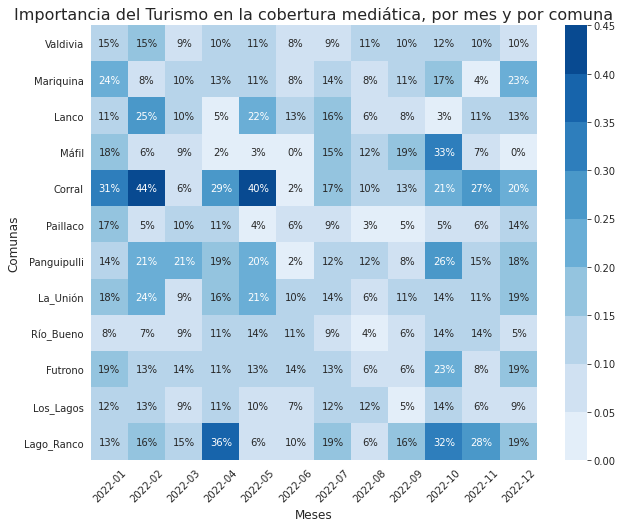

In [84]:
# Crear paleta de colores con 5 tonos de azul
cmap = ListedColormap(sns.color_palette("Blues", n_colors=9, desat=1).as_hex())

# Crear gráfico
sns.set_style('whitegrid') # Agregado para cambiar el estilo
fig, ax = plt.subplots(figsize=(10, 8))

# Crear heatmap con escala limitada a 0-0.5 y la nueva paleta de colores
sns.heatmap(ratio_per_month.T, cmap=cmap, annot=True, fmt='.0%', ax=ax, vmin=0.0, vmax=0.45)

# Formatear etiquetas del eje X para mostrar solo el año y el mes
labels = [d.strftime('%Y-%m') for d in ratio_per_month.index]
ax.set_xticklabels(labels, rotation=45)

# Añadir título y etiquetas de los ejes
ax.set_title('Importancia del Turismo en la cobertura mediática, por mes y por comuna', fontsize=16)
ax.set_xlabel('Meses', fontsize=12)
ax.set_ylabel('Comunas', fontsize=12)

plt.show()

# 10. Visualizar el análisis de sentimiento por comuna (todas las noticias): Figura 5

In [86]:
dataset_cities.reset_index(drop=True, inplace=True)

In [87]:
# Lista de comunas
comunas = ["Valdivia", "Mariquina", "Lanco", "Máfil", "Corral",  "Paillaco", 
           "Panguipulli", "La_Unión", "Río_Bueno", "Futrono", "Los_Lagos", "Lago_Ranco"]

# Lista de predicciones
predicciones = ["POS", "NEU", "NEG"]

# Dataframe de resultados
resultados = pd.DataFrame(columns=["comuna", "POS", "NEU", "NEG"])

# Calcular el número de predicciones POS, NEU, NEG para cada comuna
for comuna in comunas:
    row = {"comuna": comuna, "POS": 0, "NEU": 0, "NEG": 0}
    for i, valor in enumerate(dataset_cities[comuna]):
        if valor == 1:
            if dataset_cities["prediction"][i] == "POS":
                row["POS"] += 1
            elif dataset_cities["prediction"][i] == "NEU":
                row["NEU"] += 1
            elif dataset_cities["prediction"][i] == "NEG":
                row["NEG"] += 1
    resultados = resultados.append(row, ignore_index=True)

resultados

,comuna,POS,NEU,NEG
0,Valdivia,449,4913,1561
1,Mariquina,71,451,166
2,Lanco,71,509,107
3,Máfil,26,310,87
4,Corral,60,462,109
5,Paillaco,168,1317,362
6,Panguipulli,144,901,206
7,La_Unión,191,1269,325
8,Río_Bueno,128,833,263
9,Futrono,152,985,284


In [88]:
resultados['sentimientos'] = (resultados['POS'] + 0.5*resultados['NEU']) / (resultados['POS'] + resultados['NEG'] + resultados['NEU'])

resultados['comuna'] = resultados['comuna'].str.replace('_', ' ')

resultados

,comuna,POS,NEU,NEG,sentimientos
0,Valdivia,449,4913,1561,0.419688
1,Mariquina,71,451,166,0.430959
2,Lanco,71,509,107,0.473799
3,Máfil,26,310,87,0.427896
4,Corral,60,462,109,0.461173
5,Paillaco,168,1317,362,0.447482
6,Panguipulli,144,901,206,0.47522
7,La Unión,191,1269,325,0.462465
8,Río Bueno,128,833,263,0.444853
9,Futrono,152,985,284,0.453554


In [90]:
# Unir los datos de resultados con el shapefile
comunas_resultados = territory.merge(resultados, left_on='Comuna', right_on='comuna')

# Redondear el puntaje de sentimientos a 3 decimales
comunas_resultados['sentimientos'] = comunas_resultados['sentimientos'].apply(lambda x: round(x, 3))

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

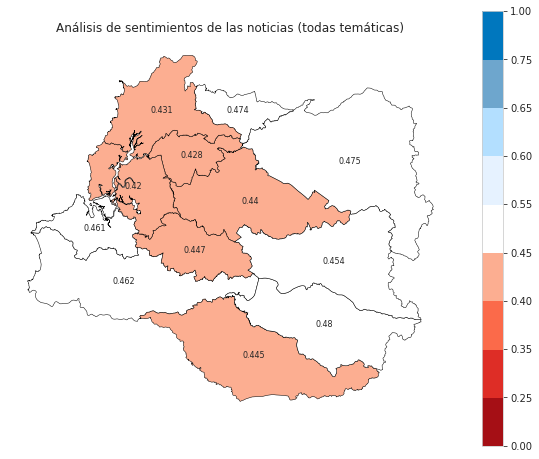

In [91]:
# Definir los límites de la escala de color y los colores correspondientes
limits = [0, 0.25, 0.35, 0.4, 0.45, 0.55, 0.6, 0.65, 0.75, 1]
colors_list = ['#A50F15', '#DE2D26', '#FB6A4A', '#FCAE91', '#FFFFFF','#e6f2ff', '#b3dfff', '#6ea6cd', '#0077be']

# Crear el mapa
fig, ax = plt.subplots(figsize=(10, 8))

# Crear la escala de color personalizada
cmap = colors.ListedColormap(colors_list)
norm = colors.BoundaryNorm(limits, cmap.N)

# Graficar las comunas en el mapa
comunas_resultados.plot(column='sentimientos', cmap=cmap, norm=norm, linewidth=0.5, edgecolor='black', legend=True, ax=ax)
ax.set_title('Análisis de sentimientos de las noticias (todas temáticas)')
ax.set_axis_off()

# Agregar puntaje de sentimiento en el centro de cada polígono
for idx, row in comunas_resultados.iterrows():
    centroid = row['geometry'].centroid
    sentimiento = row['sentimientos']
    ax.annotate(text=sentimiento, xy=(centroid.x, centroid.y), ha='center', va='center', fontsize=8)

# Agregar leyenda
cbar = plt.colorbar(ax=ax, fraction=0.03, pad=0.04, boundaries=limits, ticks=[0.125, 0.3, 0.375, 0.425, 0.5, 0.575, 0.625, 0.7, 0.875])
cbar.ax.set_yticklabels(['Negatividad extrema', 'Negatividad fuerte', 'Negatividad mediana', 'Negatividad ligera', 'Neutro', 'Positividad ligera', 'Positividad mediana', 'Positividad fuerte', 'Positividad extrema'], fontsize=8)
cbar.ax.tick_params(labelsize=8)

plt.show()


# 11. Visualizar el análisis de sentimiento por comuna en las noticias sobre turismo: Figura 6

In [92]:
dataset_cities_topic.reset_index(drop=True, inplace=True)

In [93]:
# Lista de comunas
comunas = ["Valdivia", "Mariquina", "Lanco", "Máfil", "Corral",  "Paillaco", 
           "Panguipulli", "La_Unión", "Río_Bueno", "Futrono", "Los_Lagos", "Lago_Ranco"]

# Lista de predicciones
predicciones = ["POS", "NEU", "NEG"]

# Dataframe de resultados
resultados = pd.DataFrame(columns=["comuna", "POS", "NEU", "NEG"])

# Calcular el número de predicciones POS, NEU, NEG para cada comuna
for comuna in comunas:
    row = {"comuna": comuna, "POS": 0, "NEU": 0, "NEG": 0}
    for i, valor in enumerate(dataset_cities_topic[comuna]):
        if valor == 1:
            if dataset_cities_topic["prediction"][i] == "POS":
                row["POS"] += 1
            elif dataset_cities_topic["prediction"][i] == "NEU":
                row["NEU"] += 1
            elif dataset_cities_topic["prediction"][i] == "NEG":
                row["NEG"] += 1
    resultados = resultados.append(row, ignore_index=True)

resultados

,comuna,POS,NEU,NEG
0,Valdivia,136,531,75
1,Mariquina,21,60,4
2,Lanco,19,59,4
3,Máfil,12,29,2
4,Corral,28,95,6
5,Paillaco,45,89,15
6,Panguipulli,51,140,7
7,La_Unión,59,187,11
8,Río_Bueno,32,81,2
9,Futrono,48,124,14


In [99]:
resultados['sentimientos'] = (resultados['POS'] + 0.5*resultados['NEU']) / (resultados['POS'] + resultados['NEG'] + resultados['NEU'])

resultados['comuna'] = resultados['comuna'].str.replace('_', ' ')

In [100]:
# Unir los datos de resultados con el shapefile
comunas_resultados = territory.merge(resultados, left_on='Comuna', right_on='comuna')

# Redondear el puntaje de sentimientos a 3 decimales
comunas_resultados['sentimientos'] = comunas_resultados['sentimientos'].apply(lambda x: round(x, 3))

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

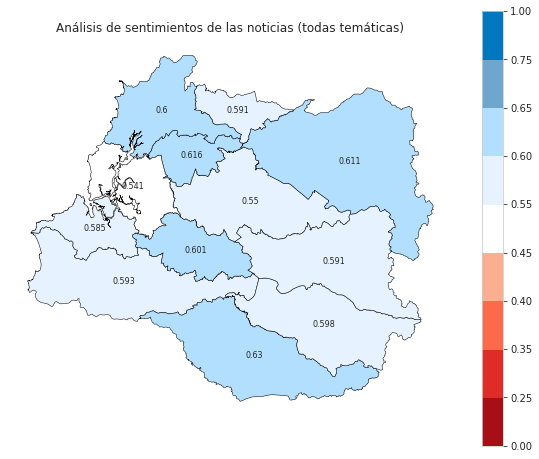

In [101]:
# Definir los límites de la escala de color y los colores correspondientes
limits = [0, 0.25, 0.35, 0.4, 0.45, 0.55, 0.6, 0.65, 0.75, 1]
colors_list = ['#A50F15', '#DE2D26', '#FB6A4A', '#FCAE91', '#FFFFFF','#e6f2ff', '#b3dfff', '#6ea6cd', '#0077be']

# Crear el mapa
fig, ax = plt.subplots(figsize=(10, 8))

# Crear la escala de color personalizada
cmap = colors.ListedColormap(colors_list)
norm = colors.BoundaryNorm(limits, cmap.N)

# Graficar las comunas en el mapa
comunas_resultados.plot(column='sentimientos', cmap=cmap, norm=norm, linewidth=0.5, edgecolor='black', legend=True, ax=ax)
ax.set_title('Análisis de sentimientos de las noticias (todas temáticas)')
ax.set_axis_off()

# Agregar puntaje de sentimiento en el centro de cada polígono
for idx, row in comunas_resultados.iterrows():
    centroid = row['geometry'].centroid
    sentimiento = row['sentimientos']
    ax.annotate(text=sentimiento, xy=(centroid.x, centroid.y), ha='center', va='center', fontsize=8)

# Agregar leyenda
cbar = plt.colorbar(ax=ax, fraction=0.03, pad=0.04, boundaries=limits, ticks=[0.125, 0.3, 0.375, 0.425, 0.5, 0.575, 0.625, 0.7, 0.875])
cbar.ax.set_yticklabels(['Negatividad extrema', 'Negatividad fuerte', 'Negatividad mediana', 'Negatividad ligera', 'Neutro', 'Positividad ligera', 'Positividad mediana', 'Positividad fuerte', 'Positividad extrema'], fontsize=8)
cbar.ax.tick_params(labelsize=8)

plt.show()

# 11. Visualizar la evolución de la cantidad y polaridad de las noticias de turismo de Panguipulli: Figura 7

In [107]:
dataset_turism_panguipulli = dataset_cities_topic[dataset_cities_topic["Panguipulli"] == 1]
dataset_turism_panguipulli = dataset_turism_panguipulli.drop('keywords_found', axis=1)

In [110]:
# convertir columna "date" a datetime si no lo está
dataset_turism_panguipulli['date'] = pd.to_datetime(dataset_turism_panguipulli['date'])

dataset_turism_panguipulli['year']=dataset_turism_panguipulli['date'].dt.year
dataset_turism_panguipulli['month']=dataset_turism_panguipulli['date'].dt.month

In [111]:
dataset_turism_panguipulli = dataset_turism_panguipulli.groupby([dataset_turism_panguipulli['year'], dataset_turism_panguipulli['month'], 'prediction']).size().reset_index(name='count')

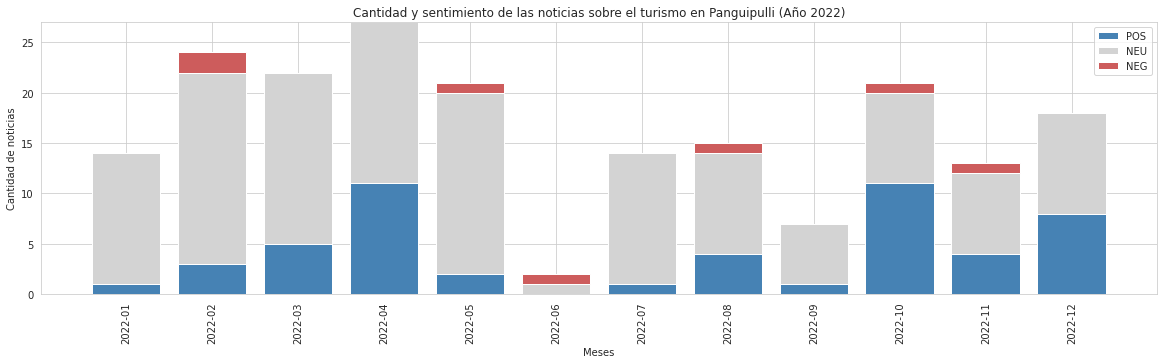

In [112]:
# crear una columna "date" a partir de "year" y "month"
dataset_turism_panguipulli["date"] = pd.to_datetime(dataset_turism_panguipulli["year"].astype(str) + "-" + dataset_turism_panguipulli["month"].astype(str) + "-01")

# utilizar pivot_table para contar los datos por mes y predicción
df_pivot = dataset_turism_panguipulli.pivot_table(index="date", columns="prediction", values="count", aggfunc=sum)

# crear una figura y un eje
fig, ax = plt.subplots()

# definir los colores para cada predicción
colors = {"POS": "steelblue", "NEU": "lightgray", "NEG": "indianred"}

# graficar las barras apiladas
x = df_pivot.index.strftime("%Y-%m")
bottom = np.zeros(len(df_pivot))
for prediction in ["POS", "NEU", "NEG"]:
    y = df_pivot[prediction].fillna(0).values
    ax.bar(x, y, bottom=bottom, color=colors[prediction],edgecolor='white', label=prediction)
    bottom += y

plt.xticks(rotation=90)
    
# ajustar el tamaño del gráfico
fig.set_size_inches(20, 5)

# agregar etiquetas y leyendas
ax.set_title("Cantidad y sentimiento de las noticias sobre el turismo en Panguipulli (Año 2022)")
ax.set_xlabel("Meses")
ax.set_ylabel("Cantidad de noticias")
ax.legend()
plt.savefig('S3_polaridad_Turismo.png')
# mostrar el gráfico
plt.show()

# 12. Cantidad de noticias por medios de prensa: Figura 9

In [114]:
dataset_turism_panguipulli = dataset_cities_topic[dataset_cities_topic["Panguipulli"] == 1]
dataset_turism_panguipulli = dataset_turism_panguipulli.drop('keywords_found', axis=1)

In [115]:
# consultar el número de filas por cada media_outlet
query = '''
    SELECT media_outlet, COUNT(*) AS numero_noticias
    FROM dataset_turism_panguipulli
    GROUP BY media_outlet
    ORDER BY numero_noticias DESC
'''

df_count_by_media_outlet = sqldf(query)

df_count_by_media_outlet

,media_outlet,numero_noticias
0,diariolaguino,59
1,centralnoticiaspanguipulli,34
2,diariodevaldivia,32
3,noticiaslosrios,20
4,diariolaunion,10
5,diariofutrono,10
6,diariolagoranco,6
7,diariomafil,5
8,diariosanjose,4
9,diariolanco,4


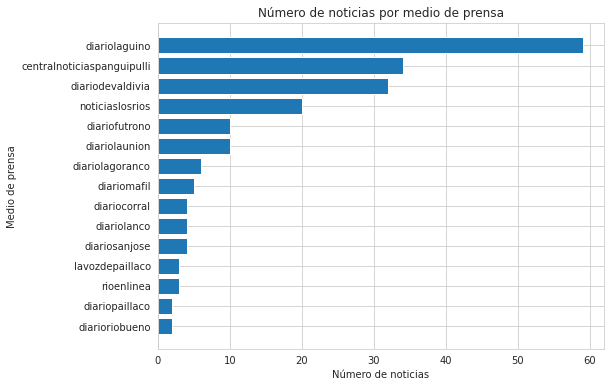

In [116]:
# ordenar el DataFrame por la columna 'count' de manera descendente
df_count_by_media_outlet_sorted = df_count_by_media_outlet.sort_values('numero_noticias', ascending=True)

# crear una figura y un eje con tamaño personalizado
fig, ax = plt.subplots(figsize=(8, 6))


# crear el gráfico de barras
ax.barh(df_count_by_media_outlet_sorted['media_outlet'], df_count_by_media_outlet_sorted['numero_noticias'])

# agregar etiquetas y títulos
ax.set_xlabel('Número de noticias')
ax.set_ylabel('Medio de prensa')
ax.set_title('Número de noticias por medio de prensa')

# mostrar el gráfico
plt.show()

# 13. Extracción de las palabras claves: Figura 8

In [120]:
matcher = Matcher(nlp.vocab)
# pattern: NOUN-de-NOUN
pattern_1 = [{"POS": "NOUN"},{"LOWER": "de"}, {"POS": "NOUN"}]
matcher.add("NOUN-de-NOUN", [pattern_1])

# pattern: NOUN-ADJ
pattern_2 = [{"POS": "NOUN"}, {"POS": "ADJ"}]
matcher.add("NOUN-ADJ", [pattern_2])

# pattern: NOUN
pattern_3 = [{"POS": "NOUN"}]
matcher.add("NOUN", [pattern_3])

In [123]:
# Agregar columna "text_summary" con valor predeterminado en blanco
dataset_turism_panguipulli['text_summary'] = ''

In [124]:
for index,row in dataset_turism_panguipulli.iterrows():
    print(index)
    title = row["title"]
    text = row["text"]
    
    text_summary=[]
    
    try:
        doc = nlp(title+". "+text)
        matches = matcher(doc)

        for match_id, start, end in matches:
            span = doc[start:end]  # The matched span
            text_summary.append(span.text)
    
        
    except:
        pass
    
    # Actualizar el valor de la columna "text_summary" en la fila actual
    dataset_turism_panguipulli.at[index, 'text_summary'] = text_summary

0
2
10
11
14
15
30
33
34
37
41
42
48
50
51
58
61
62
68
78
79
82
83
87
88
96
97
99
101
105
108
109
121
133
135
136
140
141
142
152
153
158
159
161
166
167
176
195
199
205
206
209
215
218
220
221
222
225
227
228
239
240
247
248
259
275
285
290
293
300
313
314
315
324
326
334
343
356
358
367
401
456
472
487
507
509
511
512
514
516
526
532
535
538
544
548
555
556
572
583
591
596
600
606
613
615
618
621
629
632
639
640
641
646
647
649
650
653
655
667
668
686
689
693
719
724
734
751
754
774
799
800
802
816
818
824
832
835
848
850
855
862
864
879
887
890
896
900
901
931
940
959
995
1006
1009
1013
1014
1015
1016
1019
1022
1026
1028
1049
1068
1091
1122
1129
1140
1152
1155
1164
1165
1181
1187
1196
1197
1210
1214
1225
1244
1250
1254
1294
1301
1337
1348
1355
1388
1404
1409
1414
1421
1424
1454
1468
1473
1478


In [127]:
# Crear una lista de todas las palabras clave
all_keywords = []
for keywords in dataset_turism_panguipulli['text_summary']:
    all_keywords.extend(keywords)

# Contar la frecuencia de cada palabra y ordenar la lista
word_counts = Counter(all_keywords)

# Crear diccionarios para guardar las frecuencias de cada palabra en cada categoría
pos_word_counts = {}
neu_word_counts = {}
neg_word_counts = {}

# Contar la frecuencia de cada palabra en cada categoría
for index, row in dataset_turism_panguipulli.iterrows():
    for keyword in row['text_summary']:
        if row['prediction'] == 'POS':
            pos_word_counts[keyword] = pos_word_counts.get(keyword, 0) + 1
        elif row['prediction'] == 'NEU':
            neu_word_counts[keyword] = neu_word_counts.get(keyword, 0) + 1
        else:
            neg_word_counts[keyword] = neg_word_counts.get(keyword, 0) + 1

# Combinar las frecuencias de cada palabra en un solo dataframe
count_keywords_dataframe = pd.DataFrame(word_counts.items(), columns=['palabra', 'frecuencia'])
count_keywords_dataframe['frecuencia_POS'] = count_keywords_dataframe['palabra'].map(pos_word_counts)
count_keywords_dataframe['frecuencia_NEU'] = count_keywords_dataframe['palabra'].map(neu_word_counts)
count_keywords_dataframe['frecuencia_NEG'] = count_keywords_dataframe['palabra'].map(neg_word_counts)

# Ordenar el dataframe por la frecuencia total de cada palabra
count_keywords_dataframe = count_keywords_dataframe.sort_values(by='frecuencia', ascending=False)

count_keywords_dataframe


,palabra,frecuencia,frecuencia_POS,frecuencia_NEU,frecuencia_NEG
5,comuna,414,76.0,332.0,6.0
423,horas,239,91.0,142.0,6.0
55,actividades,237,93.0,144.0,NaN
65,parte,225,72.0,147.0,6.0
31,trabajo,192,57.0,132.0,3.0
...,...,...,...,...,...
3890,poeta chileno,1,1.0,NaN,NaN
3891,jornadas de investigación,1,1.0,NaN,NaN
3892,investigación de residuos,1,1.0,NaN,NaN
3893,residuos presentes,1,1.0,NaN,NaN


In [128]:
pd.set_option('display.max_rows', 500)

count_keywords_dataframe[0:5000]

,palabra,frecuencia,frecuencia_POS,frecuencia_NEU,frecuencia_NEG
5,comuna,414,76.0,332.0,6.0
423,horas,239,91.0,142.0,6.0
55,actividades,237,93.0,144.0,NaN
65,parte,225,72.0,147.0,6.0
31,trabajo,192,57.0,132.0,3.0
...,...,...,...,...,...
518,mercado argentino,1,NaN,1.0,NaN
516,apertura de fronteras,1,NaN,1.0,NaN
514,provincias vecinas,1,NaN,1.0,NaN
3145,motor,1,NaN,NaN,1.0


# 14. Extraer ejemplos de noticias POS, NEG y NEU por cada mes de 2022: Figura 10

In [135]:
dataset_turism_panguipulli = dataset_turism_panguipulli.drop('text_summary', axis=1)

In [139]:
query = """
SELECT date, title, url, prediction, score
FROM dataset_turism_panguipulli
WHERE prediction = 'NEU'
ORDER BY score DESC
"""

result7 = pysqldf(query)
result7

,date,title,url,prediction,score
0,2022-03-02,Sepa dónde y cuándo acudir para obtener la revisión técnica en Los Ríos - Diario Laguino,https://www.diariolaguino.cl/noticia/actualidad/2022/03/sepa-donde-y-cuando-acudir-para-obtener-la-revision-tecnica-en-los-rios,NEU,0.998517
1,2022-03-23,Municipios extienden horarios en última semana para obtener el permiso de circulación 2022 - Diario Laguino,https://www.diariolaguino.cl/noticia/actualidad/2022/03/municipios-extienden-horarios-en-ultima-semana-para-obtener-el-permiso-de-circulacion-2022,NEU,0.998329
2,2022-07-11,Informan horario de invierno del complejo fronterizo Hua Hum - Diario Laguino,https://www.diariolaguino.cl/noticia/actualidad/2022/07/informan-horario-de-invierno-del-complejo-fronterizo-hua-hum,NEU,0.998077
3,2022-07-28,Escuela de Puerto Fuy tendrá transporte escolar gratuito - Diario de Valdivia,https://www.diariodevaldivia.cl/noticia/actualidad/2022/07/escuela-de-puerto-fuy-tendra-transporte-escolar-gratuito,NEU,0.997933
4,2022-05-02,Municipalidad de Panguipulli realizó su cuenta pública del año 2021,https://centralnoticias.cl/municipalidad-de-panguipulli-realizo-su-cuenta-publica-del-ano-2021-destaco-inversion-y-proyectos-en-la-comuna/,NEU,0.997875
5,2022-11-17,Positivo balance tras simulacro de erupción del volcán Mocho-Choshuenco - Diario Laguino,https://www.diariolaguino.cl/noticia/actualidad/2022/11/positivo-balance-tras-simulacro-de-erupcion-del-volcan-mocho-choshuenco,NEU,0.997843
6,2022-05-24,ONEMI actualiza Alerta Temprana Preventiva por actividad del volcán Villarrica,https://www.noticiaslosrios.cl/2022/05/24/onemi-actualiza-alerta-temprana-preventiva-por-actividad-del-volcan-villarrica/,NEU,0.997416
7,2022-12-22,Caravana Técnico Profesional del CFT de Los Ríos arribó este lunes y se quedará hasta el viernes en Panguipulli,https://www.noticiaslosrios.cl/2022/12/22/caravana-tecnico-profesional-del-cft-de-los-rios-arribo-este-lunes-y-se-quedara-hasta-el-viernes-en-panguipulli/,NEU,0.997330
8,2022-03-14,Municipalidad de Panguipulli constituye Comité de Turismo Municipal,https://www.noticiaslosrios.cl/2022/03/14/municipalidad-de-panguipulli-constituye-comite-de-turismo-municipal/,NEU,0.997131
9,2022-09-12,Conozca la parrilla programática para Fiestas Patrias en Panguipulli,https://centralnoticias.cl/conozca-la-parrilla-programatica-para-fiestas-patrias-en-panguipulli/,NEU,0.997109


In [134]:
pd.set_option('display.max_colwidth', 200)
result7["url"]

0                      https://www.diariolaguino.cl/noticia/actualidad/2022/08/preocupante-aumento-registro-parque-vehicular-en-la-region
1                                       https://centralnoticias.cl/rechazo-transversal-de-concejales-recibe-el-padem-2023-en-panguipulli/
2                    https://www.diariolaguino.cl/noticia/actualidad/2022/02/intensos-granizos-caen-en-zonas-precordilleranas-de-los-rios
3                https://centralnoticias.cl/inmobiliaria-denuncia-a-municipio-de-panguipulli-por-prohibir-vehiculos-motorizados-en-lagos/
4    https://www.noticiaslosrios.cl/2022/05/10/denuncian-ante-ministerio-publico-eventual-contaminacion-de-estero-nanguil-en-panguipulli/
5     https://www.diariolaguino.cl/noticia/actualidad/2022/06/productora-a-cargo-de-show-de-marcianeke-en-panguipulli-suspendio-el-evento
6                                      https://www.rioenlinea.cl/andinista-muere-tras-caida-en-el-volcan-mocho-choshuenco-de-panguipulli/
Name: url, dtype: object